# Ejercicio 8 - Aprendizaje por Refuerzos II
## Inteligencia Artificial - Ing. en Sistemas de Información 
## UTN Facultad Regional Villa Maria
### Natalia Bruno - Legajo: 10683

Fecha de entrega: **21/06/2017**

1. Un entorno denominado **"windy gridworld"** consiste en un agente que se mueve en una grilla formada por un conjunto de celdas, cada una de las cuales se corresponde con un estado. La particularidad de este entorno es que el mismo es atravesado de abajo hacia arriba por viento, el cual sopla siempre en la misma dirección pero con distinta fuerza en cada columna del gridworld (Ver Figura). En cada una de las celdas, el agente puede ejecutar una entre cuatro acciones posibles: norte, sur, este y oeste, las que producen el efecto de mover el agente hacia la celda adyacente de acuerdo a la acción ejecutada (de manera determinística). Sin embargo, en aquellas columnas afectadas por el viento, el efecto de las acciones que llevan al agente a alguna de dichas columnas es que el mismo es arrastrado hacia arriba tantas celdas como indique la fuerza del viento, a partir de la celda a la que debería haber arribado como efecto de la transición. Aquella acción que lleva al agente fuera de la grilla, tiene el efecto de mantener al mismo en la misma celda. Todas las acciones producen una recompensa de -1.

Para comenzar tomamos como base la siguiente implementación de SARSA para el entorno mencionado: 

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

In [2]:
# interacción en un episodio
def oneEpisode():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
        # Sarsa update
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
        currentAction = newAction
        time += 1
    return time

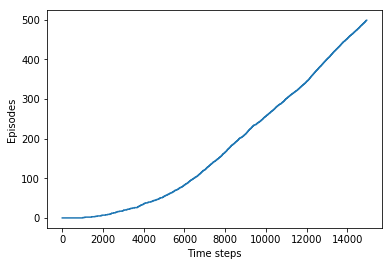

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'D']
['U', 'L', 'U', 'U', 'R', 'U', 'R', 'D', 'R', 'D']
['D', 'R', 'U', 'R', 'R', 'R', 'U', 'G', 'L', 'D']
['D', 'R', 'D', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'D', 'L']
['R', 'U', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [3]:
# Ejecutamos 500 episodios, obteniendo la politica óptima y gráfica

episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes.extend([ep] * time)
    ep += 1

plt.figure()
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)
print([str(w) for w in WIND])

### Punto 1.1

Modifique la implementación anterior para que el agente aprenda la política óptima empleando Q-Learning. Mantenga la política empleada en la implementación (e-greedy).

Para emplear Q-Learning la funcion accion-valor Q debe aproximar directamente a q*, es decir la funcion-accion valor correspondiente a la politica optima.

In [4]:
# Valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]


# Interacción en un episodio
def oneEpisodeQL():
    # Acumulador de steps en el episodio
    time = 0

    # Estado inicial
    currentState = startState

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        
        # Choose A from S using policy derived from Q e-greedy
        if np.random.binomial(1, EPSILON) == 1:
            currentAction = np.random.choice(actions)
        else:
            currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])
        
        # Take action A, obverve R, S'
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        
        # Off policy update
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (REWARD + max(stateActionValues[newState[0], newState[1], :]) -
            stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
        
        time += 1
    return time

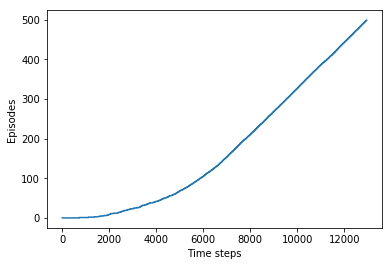

['D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'D', 'U', 'D', 'L', 'L']
['D', 'R', 'R', 'D', 'D', 'U', 'U', 'R', 'D', 'L']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [5]:
# Ejecutamos 500 episodios, obteniendo la politica óptima y gráfica

episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisodeQL()
    episodes.extend([ep] * time)
    ep += 1

plt.figure()
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)
print([str(w) for w in WIND])

### Punto 1.2

Modifique la implementación anterior para que el agente aprenda la política óptima empleando Sarsa($\lambda$). Mantenga la política empleada en la implementación (e-greedy).

In [6]:
# Valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Seteamos valores de las trazas para cada estado
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Lambda = parametro de decaimiento de la traza
LAMBDA = 0.5

# Interacción en un episodio
def oneEpisodeSlamda():
    # Acumulador de steps en el episodio
    time = 0

    # Estado inicial
    currentState = startState

    # Selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # iIteractuar hasta arribar al estado objetivo
    while currentState != goalState:
        # Take action a, observe r, s'
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        
        # Choose a' from s' using policy derived from Q e-greedy
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
        
        # Sarsa(lambda) update
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] - stateActionValues[currentState[0], currentState[1], currentAction])
        
        e[currentState[0]][currentState[1]][currentAction] += 1 
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for a in actions:
                    stateActionValues[i, j, a] += ALPHA * (delta) * e[i][j][a]
                
                    e[i][j][a] = LAMBDA * e[i][j][a]     
            
        currentState = newState
        currentAction = newAction
        time += 1
    return time

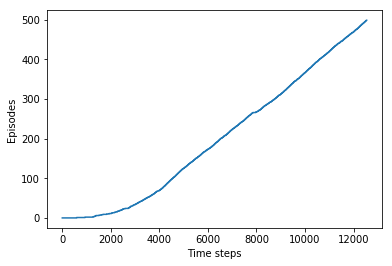

['D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'R', 'D', 'R', 'R', 'D']
['D', 'D', 'R', 'U', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'D', 'R', 'U', 'D', 'L', 'L']
['D', 'D', 'D', 'R', 'R', 'U', 'U', 'D', 'R', 'U']
['L', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'U']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [7]:
# Ejecutamos 500 episodios, obteniendo la politica óptima y gráfica
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisodeSlamda()
    episodes.extend([ep] * time)
    ep += 1
    
plt.figure()
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)
print([str(w) for w in WIND])

### Punto 1.3

Compare la convergencia de la implementación original respecto a la implementación de Q-Learning y Sarsa($\lambda$) empleando una gráfica de Steps Acumulados Promedio vs. Episodio.

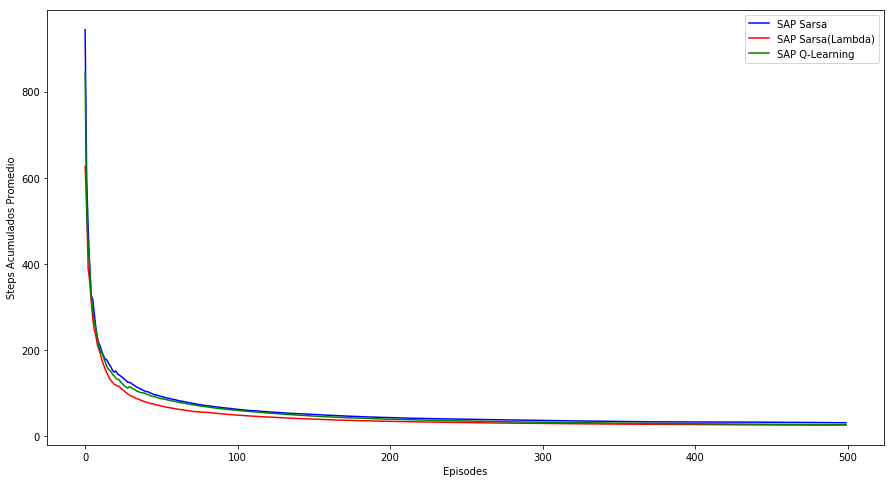

In [8]:
episodeLimit = 500

ep = 0
episodesS = []

# Seteamos el entorno inicial para la grafica original Sarsa
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Creamos un vector donde iremos guardando los Steps Acumulados Promedio por episodio
times = []
while ep < episodeLimit:
    times.append(oneEpisode())
    episodesS.append(np.sum(times)/(len(times)))
    ep += 1

ep = 0
episodesL = []

# Seteamos entorno inicial para la grafica Sarsa(Lambda)
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Trazas
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Lambda = parametro de decaimiento de la traza
LAMBDA = 0.5
times = []
while ep < episodeLimit:
    times.append(oneEpisodeSlamda())
    episodesL.append(np.sum(times)/(len(times)))
    ep += 1

# Seteamos entorno inicial para la grafica Q-Learning
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    
ep = 0
episodesQ = []
times = []
while ep < episodeLimit:
    times.append(oneEpisodeQL())
    episodesQ.append(np.sum(times)/(len(times)))
    ep += 1
    
plt.figure(figsize=(15, 8))
plt.plot(episodesS, 'b', label='SAP Sarsa')
plt.plot(episodesL, 'r', label="SAP Sarsa(Lambda)")
plt.plot(episodesQ, 'g', label="SAP Q-Learning")
plt.xlabel('Episodes')
plt.ylabel('Steps Acumulados Promedio')
plt.legend(loc='best') 
plt.show()

### Punto 1.4

Muestre el resultado de la política aprendida en cada caso.

#### SARSA

In [9]:
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes.extend([ep] * time)
    ep += 1

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)

['L', 'R', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'D', 'U', 'R', 'U', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'U', 'D', 'R', 'U', 'U', 'R', 'D']
['R', 'R', 'D', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'D', 'L', 'L']
['L', 'R', 'U', 'R', 'R', 'U', 'U', 'D', 'R', 'U']
['L', 'D', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'R']


#### Q-Learning

In [10]:
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisodeQL()
    episodes.extend([ep] * time)
    ep += 1

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)

['L', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'R', 'L', 'L']
['L', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'D']


#### SARSA(Lambda)

In [11]:
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisodeSlamda()
    episodes.extend([ep] * time)
    ep += 1

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['D', 'U', 'U', 'U', 'R', 'R', 'R', 'R', 'U', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'L', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'R', 'R', 'G', 'R', 'D']
['U', 'U', 'R', 'R', 'R', 'D', 'U', 'D', 'L', 'L']
['U', 'R', 'U', 'R', 'U', 'U', 'U', 'D', 'L', 'L']
['R', 'R', 'U', 'U', 'U', 'U', 'U', 'U', 'D', 'L']


### Punto 1.5

Modifique la implementación en 1.2 empleando los King's Moves (Ver Figura Windy Gridworld)

In [12]:
# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTION_UPRIGHT = 4
ACTION_DOWNRIGHT = 5
ACTION_UPLEFT = 6
ACTION_DOWNLEFT = 7

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 8))
startState = [3, 0]
goalState = [3, 7]
actionsKing = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UPRIGHT, ACTION_DOWNRIGHT, ACTION_UPLEFT, ACTION_DOWNLEFT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        destination[ACTION_UPRIGHT] = [max(i - 1 - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        destination[ACTION_DOWNRIGHT] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), min(j + 1, WORLD_WIDTH - 1)]
        destination[ACTION_UPLEFT] = [max(i - 1 - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_DOWNLEFT] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), max(j - 1, 0)]
        actionDestination[-1].append(destination)

#Seteo valores de las trazas para cada estado
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 8))

#Lambda = parametro de decaimiento de la traza
LAMBDA = 0.5

# interacción en un episodio
def oneEpisodeKing():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actionsKing)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        # Take action a, observe r, s'
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        
        # Choose a' from s' using policy derived from Q e-greedy
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actionsKing)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
        
        # Sarsa(lambda) update
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] - stateActionValues[currentState[0], currentState[1], currentAction])
        
        e[currentState[0]][currentState[1]][currentAction] += 1 
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for a in actionsKing:
                    stateActionValues[i, j, a] += ALPHA * (delta) * e[i][j][a]
                    
                    e[i][j][a] = LAMBDA * e[i][j][a]     
            
        currentState = newState
        currentAction = newAction
        time += 1
    return time

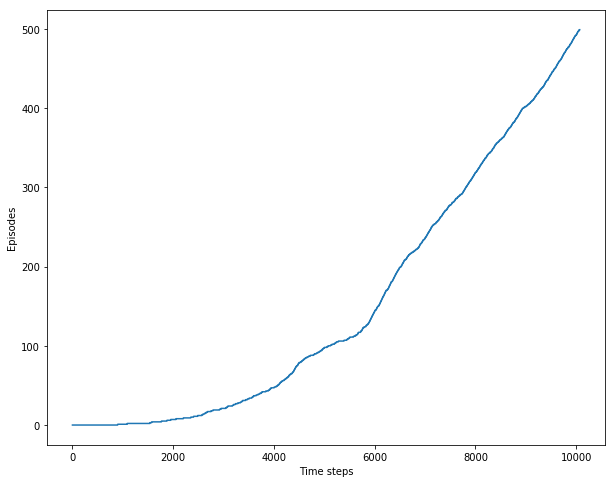

['U', 'U', 'D', 'UR', 'UR', 'R', 'R', 'R', 'DR', 'DR']
['D', 'DR', 'D', 'DR', 'DR', 'UR', 'R', 'UR', 'DR', 'D']
['DR', 'DR', 'UR', 'UR', 'D', 'R', 'R', 'DR', 'DR', 'DL']
['DR', 'D', 'D', 'DL', 'DR', 'R', 'DL', 'G', 'DL', 'L']
['DR', 'DR', 'D', 'DL', 'R', 'UR', 'D', 'D', 'L', 'DL']
['R', 'UR', 'D', 'DR', 'DR', 'DR', 'R', 'UR', 'UL', 'D']
['DR', 'R', 'UR', 'DR', 'R', 'UR', 'D', 'U', 'DL', 'U']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [13]:
# Ejecutamos 500 episodios, obteniendo la politica óptima y gráfica
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisodeKing()
    episodes.extend([ep] * time)
    ep += 1
    
plt.figure(figsize=(10,8))
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
        elif bestAction == ACTION_UPRIGHT:
            optimalPolicy[-1].append('UR')
        elif bestAction == ACTION_DOWNRIGHT:
            optimalPolicy[-1].append('DR')
        elif bestAction == ACTION_UPLEFT:
            optimalPolicy[-1].append('UL')
        elif bestAction == ACTION_DOWNLEFT:
            optimalPolicy[-1].append('DL')
for row in optimalPolicy:
    print(row)
print([str(w) for w in WIND])

### Punto 1.6

Modifique la implementación en 1.2 asumiendo que la fuerza del viento varía de manera equiprobable entre el valor A  establecido originalmente y A+1, A-1, el cual se determina para cada transición efectuada.

In [14]:
def fuerzaViento(f):
    if WIND[f] != 0:
        posibles = [WIND[f]+1, WIND[f]-1, WIND[f]]

        fuerza = np.random.choice(posibles)
    else: 
        fuerza = WIND[f]
        
    return fuerza

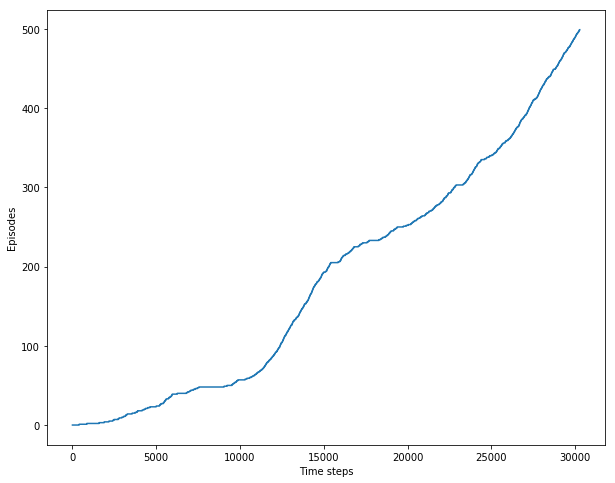

['L', 'D', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['D', 'D', 'D', 'U', 'R', 'R', 'R', 'R', 'R', 'D']
['D', 'R', 'R', 'R', 'U', 'R', 'R', 'R', 'R', 'D']
['D', 'L', 'U', 'R', 'R', 'R', 'U', 'G', 'R', 'D']
['D', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'L', 'D']
['R', 'R', 'D', 'R', 'R', 'D', 'R', 'D', 'L', 'L']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [15]:
# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
def elvientocambia():
    actionDestination = []
    for i in range(0, WORLD_HEIGHT):
        actionDestination.append([])
        for j in range(0, WORLD_WIDTH):
            destination = dict()
            destination[ACTION_UP] = [max(i - 1 - fuerzaViento(j), 0), j]
            destination[ACTION_DOWN] = [max(min(i + 1 - fuerzaViento(j), WORLD_HEIGHT - 1), 0), j]
            destination[ACTION_LEFT] = [max(i - fuerzaViento(j), 0), max(j - 1, 0)]
            destination[ACTION_RIGHT] = [max(i - fuerzaViento(j), 0), min(j + 1, WORLD_WIDTH - 1)]
            actionDestination[-1].append(destination)
            
    return actionDestination

#Seteo valores de las trazas para cada estado
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

#Lambda = parametro de decaimiento de la traza
LAMBDA = 0.5

# interacción en un episodio
def oneEpisodeSlamda():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState
    
    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        
        #Generamos un nuevo entorno para cada episodio ya que el viento varía para cada vez que se ejecuta una accion
        actionDestination = elvientocambia()
    
        # Take action a, observe r, s'
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        
        # Choose a' from s' using policy derived from Q e-greedy
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
        
        # Sarsa(lambda) update
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] - stateActionValues[currentState[0], currentState[1], currentAction])
        
        e[currentState[0]][currentState[1]][currentAction] += 1 
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for a in actions:
                    stateActionValues[i, j, a] += ALPHA * (delta) * e[i][j][a]
                
                    e[i][j][a] = LAMBDA * e[i][j][a]     
            
        currentState = newState
        currentAction = newAction
        time += 1
    return time

# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes = []
while ep < episodeLimit:
    time = oneEpisodeSlamda()
    episodes.extend([ep] * time)
    ep += 1

plt.figure(figsize=(10,8))
plt.plot(episodes)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicy = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicy[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicy[-1].append('R')
for row in optimalPolicy:
    print(row)
print([str(w) for w in WIND])

### Punto 1.7

Analice la convergencia de Sarsa($\lambda$) en 1.6 para 4 valores distintos de $\lambda$.

In [16]:
lambdas = np.linspace(0.1, 0.8, 9)
print(lambdas)

[ 0.1     0.1875  0.275   0.3625  0.45    0.5375  0.625   0.7125  0.8   ]


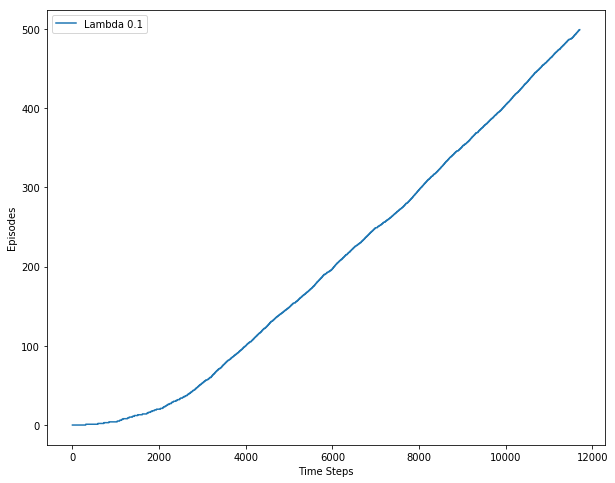

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['L', 'R', 'R', 'R', 'R', 'R', 'U', 'D', 'R', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'U', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'R', 'U', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'D', 'R', 'R', 'U', 'U', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


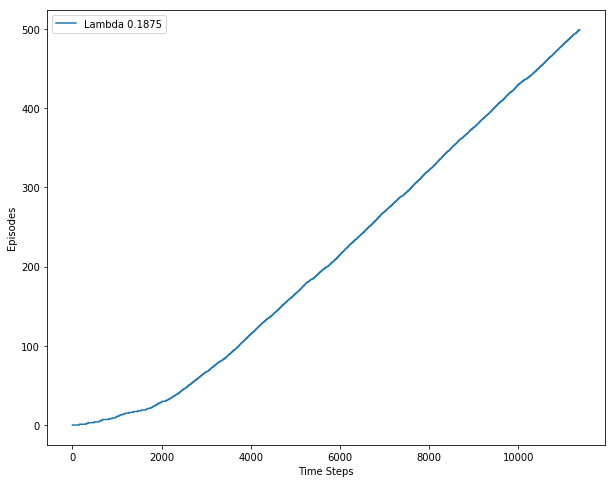

['U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['U', 'U', 'R', 'U', 'R', 'U', 'R', 'R', 'L', 'D']
['R', 'R', 'R', 'R', 'U', 'R', 'R', 'U', 'R', 'D']
['R', 'U', 'U', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['U', 'D', 'D', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'D', 'U', 'U', 'D', 'R', 'L']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


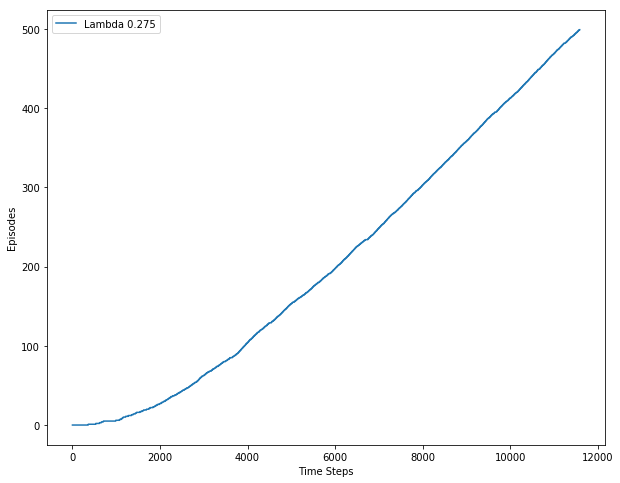

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'U', 'U', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'D', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['D', 'U', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'D']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


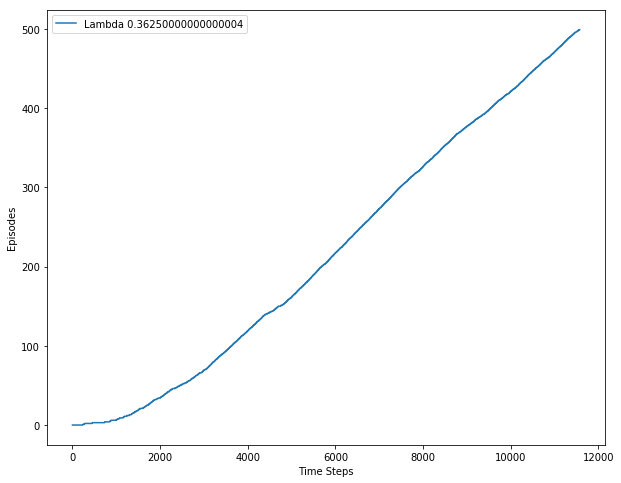

['U', 'D', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'D', 'R', 'U', 'R', 'R', 'R', 'R', 'U', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'G', 'R', 'D']
['R', 'R', 'D', 'D', 'R', 'U', 'U', 'D', 'L', 'D']
['D', 'D', 'R', 'R', 'R', 'U', 'U', 'D', 'L', 'L']
['D', 'R', 'L', 'R', 'U', 'U', 'U', 'U', 'R', 'D']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


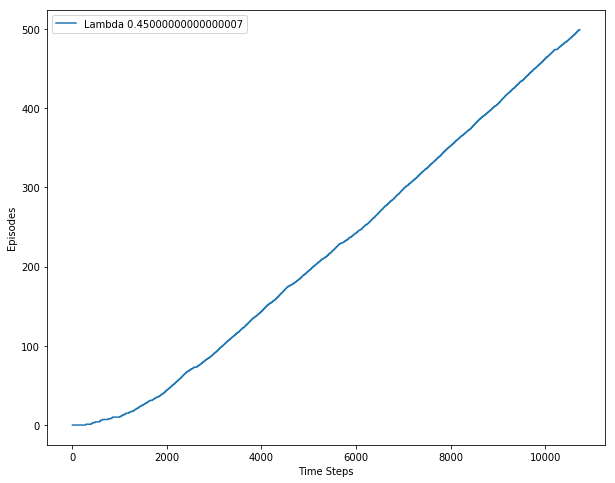

['R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'U', 'R', 'R', 'R', 'L', 'L', 'U', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'D', 'U', 'R', 'R', 'R', 'L', 'G', 'R', 'D']
['U', 'R', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['U', 'D', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'L']
['U', 'R', 'D', 'D', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


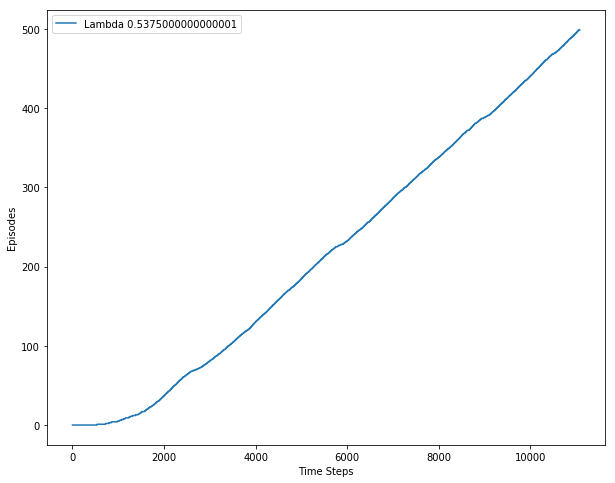

['R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'D', 'U', 'R', 'U', 'D', 'U', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'D', 'G', 'R', 'D']
['R', 'R', 'D', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['D', 'D', 'R', 'R', 'R', 'U', 'U', 'U', 'D', 'U']
['D', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


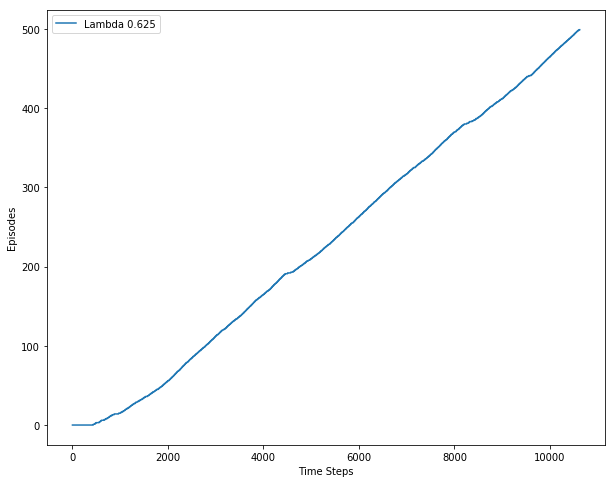

['D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'R', 'L', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'L', 'R', 'U', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'L', 'G', 'R', 'D']
['R', 'R', 'D', 'U', 'R', 'R', 'U', 'D', 'L', 'L']
['L', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'D']
['R', 'R', 'L', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


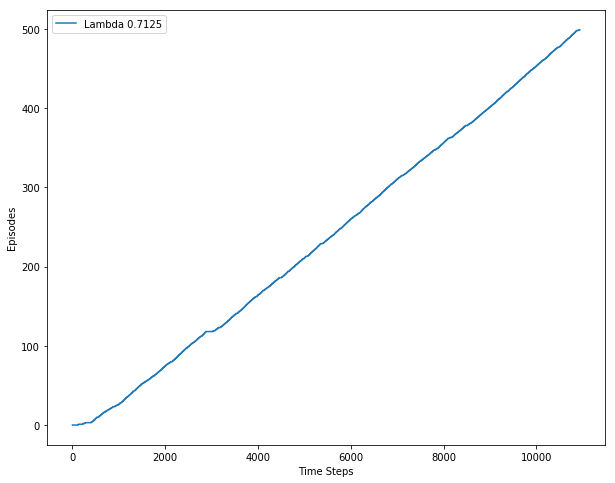

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'R', 'D', 'R', 'R', 'U', 'D', 'R', 'R', 'D']
['R', 'R', 'R', 'U', 'U', 'U', 'D', 'G', 'R', 'D']
['U', 'R', 'R', 'R', 'R', 'U', 'U', 'L', 'L', 'L']
['U', 'R', 'U', 'R', 'R', 'U', 'U', 'R', 'D', 'L']
['R', 'R', 'D', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


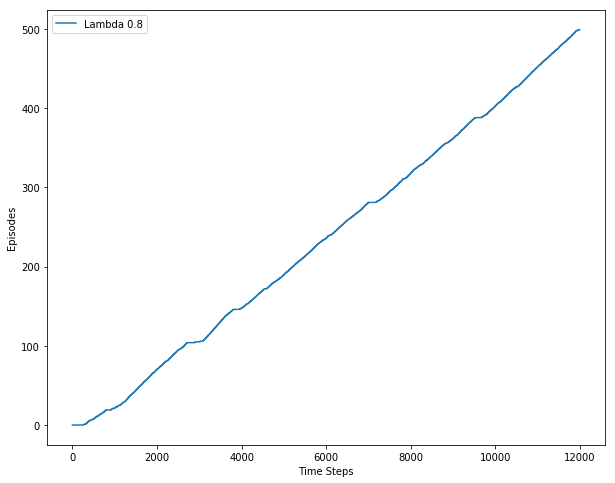

['D', 'L', 'L', 'R', 'D', 'D', 'L', 'R', 'R', 'D']
['D', 'D', 'L', 'L', 'D', 'R', 'L', 'R', 'R', 'D']
['R', 'R', 'R', 'D', 'U', 'D', 'L', 'D', 'U', 'D']
['U', 'R', 'D', 'R', 'U', 'R', 'L', 'G', 'R', 'D']
['R', 'R', 'R', 'U', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'R', 'U', 'U']
['L', 'L', 'U', 'D', 'U', 'U', 'U', 'U', 'R', 'L']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [17]:
def oneEpisodeSlamda(l):
        # acumulador de steps en el episodio
        time = 0

        # estado inicial
        currentState = startState

        # selección de acción basade en epsilon-greedy
        if np.random.binomial(1, EPSILON) == 1:
            currentAction = np.random.choice(actions)
        else:
            currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

        # interactuar hasta arribar al estado objetivo
        while currentState != goalState:
            # Take action a, observe r, s'
            newState = actionDestination[currentState[0]][currentState[1]][currentAction]

            # Choose a' from s' using policy derived from Q e-greedy
            if np.random.binomial(1, EPSILON) == 1:
                newAction = np.random.choice(actions)
            else:
                newAction = np.argmax(stateActionValues[newState[0], newState[1], :])

            # Sarsa(lambda) update
            delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] - stateActionValues[currentState[0], currentState[1], currentAction])

            e[currentState[0]][currentState[1]][currentAction] += 1 

            for i in range(0, WORLD_HEIGHT):
                for j in range(0, WORLD_WIDTH):
                    for a in actions:
                        stateActionValues[i, j, a] += ALPHA * (delta) * e[i][j][a]

                        e[i][j][a] = l * e[i][j][a]     

            currentState = newState
            currentAction = newAction
            time += 1
        return time

graficaL = []
for l in lambdas:
    
    # se setean las variables iniciales
    e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    
    graficaL.append([])

    # Cantidad de episodios
    episodeLimit = 500
    ep = 0
    time = 0
    episodesL = []
    times = []
    while ep < episodeLimit:
        times.append(oneEpisodeSlamda(l))
        graficaL[-1].append(np.sum(times)/(len(times)))
        
        time = oneEpisodeSlamda(l)
        episodesL.extend([ep] * time)
        ep += 1

    plt.figure(figsize=(10, 8))
    plt.plot(episodesL, label="Lambda {}".format(l))
    plt.xlabel('Time Steps')
    plt.ylabel('Episodes')
    plt.legend(loc='best') 
    plt.show()

    # Selección Greedy sobre la política...
    optimalPolicy = []
    for i in range(0, WORLD_HEIGHT):
        optimalPolicy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == goalState:
                optimalPolicy[-1].append('G')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == ACTION_UP:
                optimalPolicy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimalPolicy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimalPolicy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimalPolicy[-1].append('R')
    for row in optimalPolicy:
        print(row)
    print([str(w) for w in WIND])

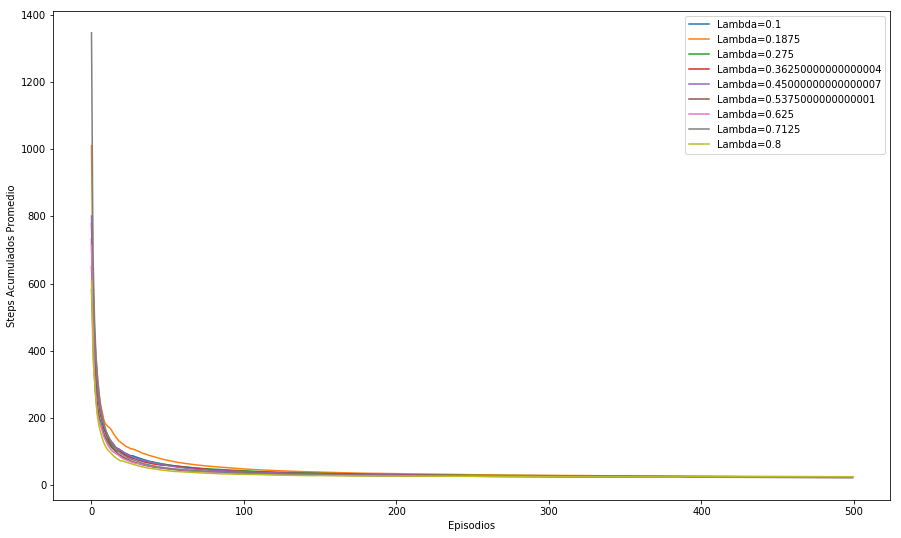

In [18]:
plt.figure(figsize=(15, 9))
indice = 0
for row in graficaL:
    plt.plot(row, label='Lambda={}'.format(lambdas[indice]))
    indice += 1

plt.xlabel('Episodios')
plt.ylabel('Steps Acumulados Promedio')
plt.legend(loc='best') 
plt.show()